### Is Gun Violence in Boston Trending Up or Down?

The issue of gun violence in the United States seems to be escalating annually. In discussions with international friends, I've learned many are apprehensive about visiting the U.S. due to this concern—a perspective that may seem foreign to those of us native to the country.

My engagement with this topic extends to a personal project: a short independent documentary on gun violence that I produced. This work aired on PBS and garnered recognition at various film festivals, including RiverRun and IndieGrits.

Turning to my home city, Boston, Massachusetts is touted as the state with the lowest incidence of gun violence in the U.S., a reassuring fact for residents. Yet, the crucial question remains: What is the trend in Massachusetts? Is the state experiencing a decline or a rise in gun violence?

**Let's find out**.

### The Data

We'll be examining two key datasets for this analysis:

1. **Boston Police Department Shootings Data**
    - This dataset is recognized for its thorough organization and sourcing.
    - Boston's commitment to data transparency is highlighted by the 2023 ordinance from the Boston City Council, mandating the BPD to meticulously track and report all seized firearms. The comprehensive data is updated weekly and can be found [here](https://data.boston.gov/dataset/boston-police-department-firearm-recovery-counts). Additionally, the dataset specific to shootings is accessible [here](https://data.boston.gov/dataset/shootings).

2. **NOAA Weather Data**
    - Similarly well-sourced and organized, this dataset focuses on Average Temperature and Precipitation at Logan International Airport.
    - It offers complete daily records from 2015 to 2023, a level of consistency unmatched by other sources.
    - Although compiling data from various stations within Boston is possible, utilizing data from Logan International Airport streamlines the process without compromising the quality of information.
    - Access the data [here](https://www.ncei.noaa.gov/cdo-web/).

These datasets provide a solid foundation for our analysis, enabling us to delve into the intricacies of gun violence trends and weather patterns in Boston.

In [1]:
# importing some common libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Some Notes

This data presents several intriguing details, such as the police district involved, victim gender, victim race, and whether the incidents involved multiple victims.

It's crucial to highlight that this dataset excludes cases of self-inflicted gunshot wounds and incidents classified as justifiable shootings.

Our focus here is strictly on illegal incidents, offering a more targeted perspective on gun violence in the area.

In [2]:
# importing data
shootings = pd.read_csv('data/boston_shootings.csv')
shootings.head()

,incident_num,shooting_date,district,shooting_type_v2,victim_gender,victim_race,victim_ethnicity_NIBRS,multi_victim
0,I152000196-00,2015-01-01 13:30:00+00,C11,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
1,I152000879-00,2015-01-04 01:58:00+00,E18,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
2,I152001014-00,2015-01-04 18:52:00+00,E5,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
3,I152002232-00,2015-01-08 22:45:00+00,B2,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,t
4,I152002233-00,2015-01-08 22:45:00+00,B2,Non-Fatal,Female,Black or African American,Not Hispanic or Latinx,t


In [3]:
# cleaning up data

# converting the incident date to a pandas datetime object
shootings['shooting_date'] = pd.to_datetime(shootings['shooting_date'])
shootings['shooting_date'] = shootings['shooting_date'].dt.date
shootings['shooting_date'] = pd.to_datetime(shootings['shooting_date'])

### Tracking Incidents on a Weekly Basis

To analyze the data on a weekly basis, we'll first introduce a new column populated with the value 1. This addition will facilitate our analysis when grouping the data by week. By summing this column within each weekly group, we can easily calculate the total number of shootings that occurred in any given week.

In [4]:
# adding an incident_count column, one for each occurence
shootings['incident_count'] = 1

# grouping by day and sum only the incident_count column
shootings_daily = shootings.groupby(['shooting_date']).sum().reset_index()

In [5]:
# read in weather data in 3 parts because of limitations on the NOAA API
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

weather = pd.concat([weather1, weather2, weather3])

# isolating the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [6]:
# merging the shootings data with the weather data

# adding the shootings data to the weather data
# we want to merge the shootings into the weather data
# because we want an entry for every single day, even if there were no shootings
weather = weather.merge(shootings_daily, left_on='DATE', right_on='shooting_date', how='left')

# dropping the shooting_date column now that we've merged
weather = weather.drop(columns=['shooting_date'])

# rewriting weather data to a new variable we'll use for now
shootings_daily = weather

# replacing NaNs with 0s in the incident_count column
shootings_daily['incident_count'] = shootings_daily['incident_count'].fillna(0)

# isolating the columns we want
shootings_daily = shootings_daily[['DATE', 'AWND', 'PRCP', 'TAVG', 'incident_count']]

In [7]:
# new dataframe which tracks incidents per week
shootings_weekly = shootings_daily.resample('W-Mon', on='DATE').sum().reset_index().sort_values(by='DATE')

shootings_weekly.head()

,DATE,AWND,PRCP,TAVG,incident_count
0,2015-01-05,67.79,1.19,166,3.0
1,2015-01-12,83.67,0.23,145,5.0
2,2015-01-19,80.52,0.27,189,2.0
3,2015-01-26,78.29,0.81,208,11.0
4,2015-02-02,102.91,1.85,144,0.0


### Visualizing the Data

The notion that gun violence escalates during the summer months is well acknowledged. To illustrate this trend and provide a clearer understanding of its scope:
- The weeks classified as summer are highlighted in red on the chart.
- We've represented the raw data with a faded blue line.
- Additionally, to smooth out fluctuations and highlight longer-term trends, we've applied a 5-week moving average, shown with an orange line.

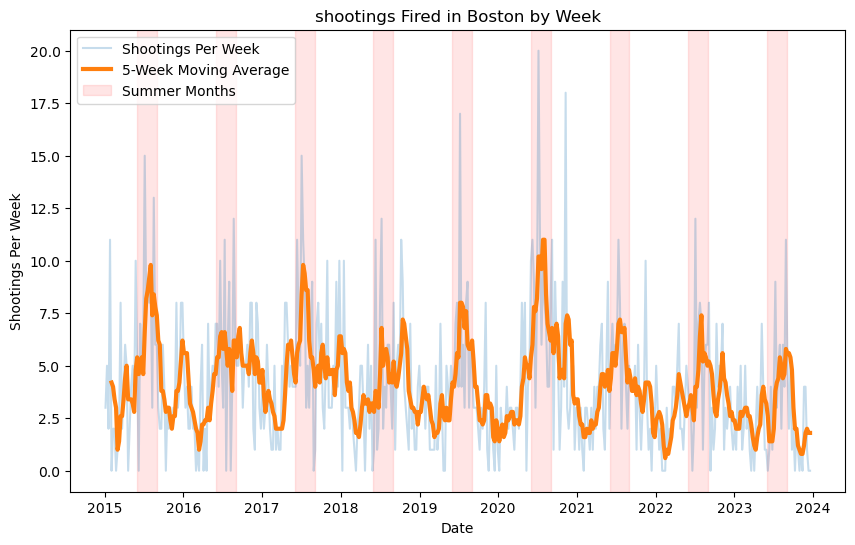

In [8]:
# adding a moving average to the plot with a thicker line
plt.figure(figsize=(10,6))
plt.plot(shootings_weekly['DATE'], shootings_weekly['incident_count'], alpha=0.25)
plt.plot(shootings_weekly['DATE'], shootings_weekly['incident_count'].rolling(5).mean(), linewidth=3)
plt.title('shootings Fired in Boston by Week')

# plotting the summer months in as vertical red bars
plt.axvspan('2015-06-01', '2015-09-01', color='red', alpha=0.1)
plt.axvspan('2016-06-01', '2016-09-01', color='red', alpha=0.1)
plt.axvspan('2017-06-01', '2017-09-01', color='red', alpha=0.1)
plt.axvspan('2018-06-01', '2018-09-01', color='red', alpha=0.1)
plt.axvspan('2019-06-01', '2019-09-01', color='red', alpha=0.1)
plt.axvspan('2020-06-01', '2020-09-01', color='red', alpha=0.1)
plt.axvspan('2021-06-01', '2021-09-01', color='red', alpha=0.1)
plt.axvspan('2022-06-01', '2022-09-01', color='red', alpha=0.1)
plt.axvspan('2023-06-01', '2023-09-01', color='red', alpha=0.1)

plt.legend(['Shootings Per Week', '5-Week Moving Average', 'Summer Months'])

plt.xlabel('Date')
plt.ylabel('Shootings Per Week')
plt.show()

### Calculating Hours of Daylight

As summer approaches, we observe two significant changes: a rise in average temperature and an increase in daylight hours. This can logically contribute to more shootings, as longer daylight hours mean more people are outdoors, potentially leading to more interactions. In contrast, during winter, there's a general preference for staying indoors (including myself).

The mathematical function used to calculate daylight hours isn't my original creation. Credit goes to Jake Vanderplaas and some assistance from GPT. To ensure accuracy, I cross-verified the function's results with recorded daylight hours on several random dates.

In [9]:
# adding a function to calculate daylight hours
def hours_of_daylight(date, latitude=42.36):
    """Compute the hours of daylight for the given date"""
    # Constants
    axial_tilt = 23.44
    days_in_year = 365.25

    # Day of the year
    day_of_year = date.timetuple().tm_yday

    # Declination angle calculation
    declination = axial_tilt * np.sin(np.radians((360 / days_in_year) * (day_of_year - 81)))

    # Hour angle calculation
    hour_angle = np.arccos(-np.tan(np.radians(latitude)) * np.tan(np.radians(declination)))

    # Daylight hours calculation
    daylight_hours = 2 * np.degrees(hour_angle) / 15

    return daylight_hours

# Applying the function to each date in the DataFrame
shootings_weekly['daylight_hours'] = shootings_weekly['DATE'].apply(hours_of_daylight)

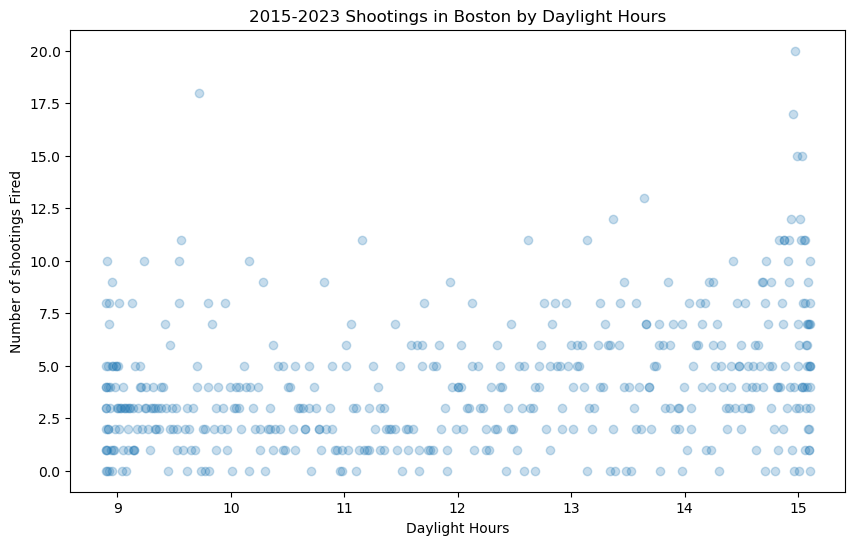

In [10]:
# plotting the number of shootings against the number of daylight hours
plt.figure(figsize=(10,6))
plt.scatter(shootings_weekly['daylight_hours'], shootings_weekly['incident_count'], alpha=0.25)
plt.title('2015-2023 Shootings in Boston by Daylight Hours')
plt.xlabel('Daylight Hours')
plt.ylabel('Number of shootings Fired')
plt.show()

### Accounting for Daylight

Incorporating daylight into our analysis reveals a notable pattern: with each additional hour of daylight, there's an average increase of 0.44 shootings per week. While this might not represent a major trend, it is a significant detail that should not be overlooked in understanding the dynamics of gun violence.

Model slope:     0.44408823159484234
Model intercept: -1.2440122524946755
R^2:             0.09445381707063394


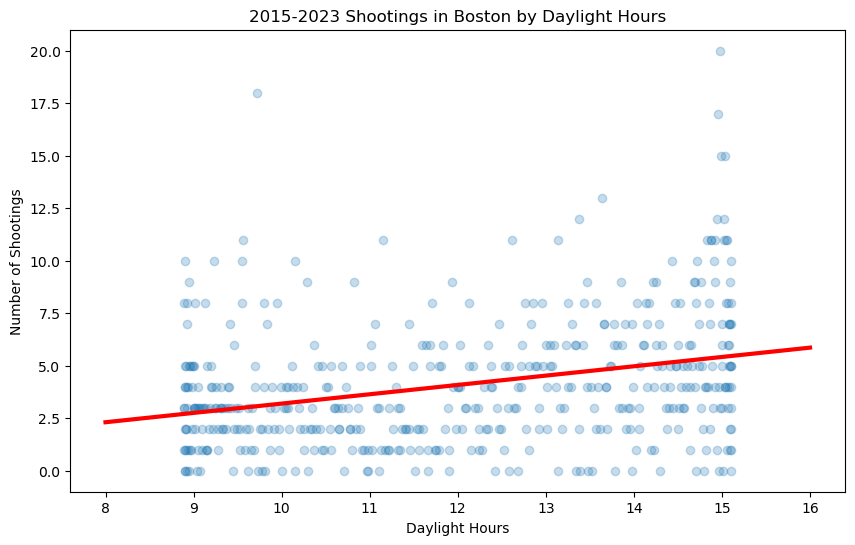

In [11]:
# modeling the relationship between daylight hours and shootings
from sklearn.linear_model import LinearRegression

X = shootings_weekly['daylight_hours'].values.reshape(-1, 1)
y = shootings_weekly['incident_count'].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)

shootings_weekly['daylight_trend'] = reg.predict(X)
shootings_weekly['daylight_corrected_total'] = shootings_weekly['incident_count'] - shootings_weekly['daylight_trend'] + shootings_weekly['daylight_trend'].mean()

xfit = np.linspace(8, 16)
yfit = reg.predict(xfit[:, None])
plt.figure(figsize=(10,6))
plt.scatter(shootings_weekly['daylight_hours'], shootings_weekly['incident_count'], alpha=0.25)
plt.plot(xfit, yfit, linewidth=3, color='red')
plt.title("2015-2023 Shootings in Boston by Daylight Hours")
plt.xlabel('Daylight Hours')
plt.ylabel('Number of Shootings');

print("Model slope:    ", reg.coef_[0][0])
print("Model intercept:", reg.intercept_[0])
print("R^2:            ", reg.score(X, y))

### Detrending for Daylight

The goal now is to develop a model that neutralizes the impact of daylight hours on shootings. Essentially, this model aims to predict the number of shootings that would occur if daylight were not a contributing factor. This approach will help us isolate and understand other variables influencing gun violence independent of daylight variations.

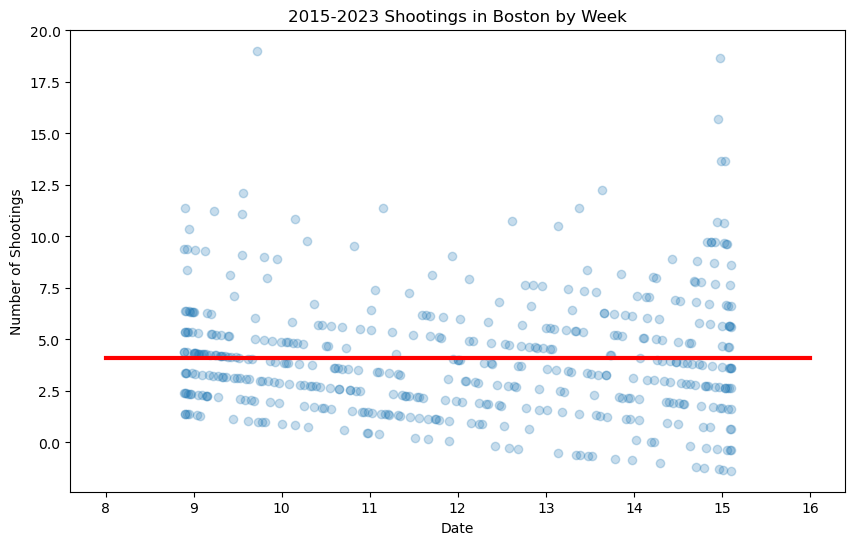

In [12]:
# detrending data by daylight hours
trend = reg.predict(shootings_weekly[['daylight_hours']].to_numpy())
shootings_weekly['detrended'] = shootings_weekly['incident_count'] - trend.flatten() + trend.mean()

# plotting the detrended data
plt.figure(figsize=(10,6))
plt.scatter(shootings_weekly['daylight_hours'], shootings_weekly['detrended'], alpha=0.25)
plt.plot(xfit, np.mean(trend) + 0 * yfit, linewidth=3, color='red')
plt.title('2015-2023 Shootings in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Number of Shootings')
plt.show()

In [13]:
# reading in weather data in 3 parts because of limitations on the NOAA API data
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

weather = pd.concat([weather1, weather2, weather3])

# isolating the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])

# converting weather to a weekly dataframe
weather_weekly = weather.resample('W-Mon', on='DATE').mean().reset_index().sort_values(by='DATE')
weather_weekly = weather_weekly[['DATE', 'PRCP', 'TAVG']]

### Accounting for Average Temperature

When we turn our attention to average temperature, the trend becomes more pronounced than with daylight hours alone. A visual inspection of the data already hints at a correlation. To further investigate this, we will employ Linear Regression analysis to quantify the relationship between average temperature and the frequency of shootings.

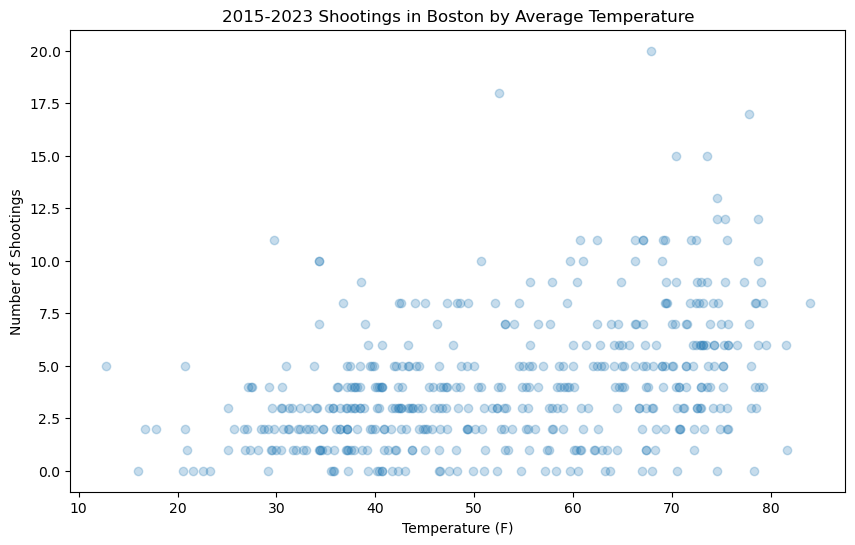

In [14]:
# plotting the number of shootings against the number of daylight hours
plt.figure(figsize=(10,6))
plt.scatter(weather_weekly['TAVG'], shootings_weekly['incident_count'], alpha=0.25)
plt.title('2015-2023 Shootings in Boston by Average Temperature')
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Shootings')
plt.show()

### Accounting for Temperature

The findings here are both intriguing and concerning. The analysis indicates that with each degree increase in temperature, the number of weekly shootings rises by approximately 0.08. This suggests a direct correlation: for every 12.5-degree increase in temperature, we can anticipate an additional shooting incident each week.

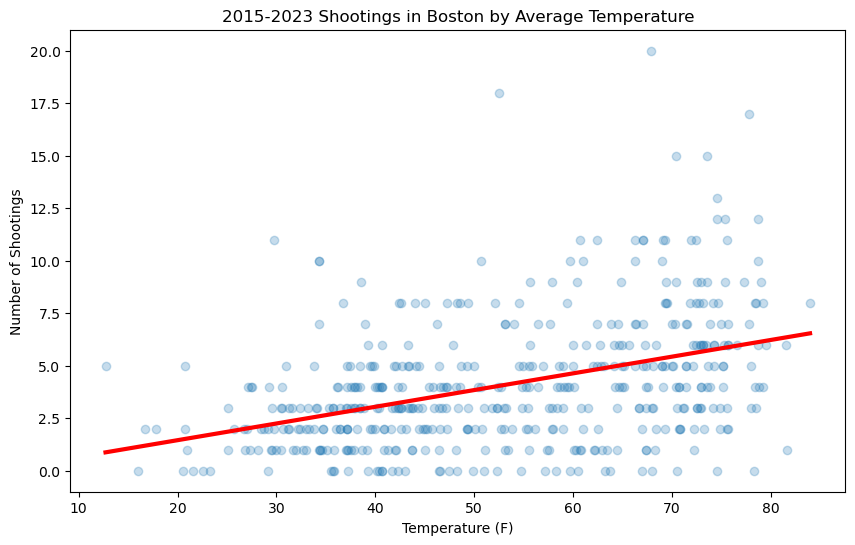

Model slope:     0.07951556216932602
Model intercept: -0.13653887974311818
R^2:             0.16982641070114823


In [15]:
# moving the temperature data to the shootings_weekly dataframe
shootings_weekly['TAVG'] = weather_weekly['TAVG']

# let's set the DATE column as the index
shootings_weekly = shootings_weekly.set_index('DATE')

# linear regression on the temperature data
from sklearn.linear_model import LinearRegression

X = shootings_weekly['TAVG'].values.reshape(-1, 1)
y = shootings_weekly['incident_count'].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)

shootings_weekly['temp_trend'] = reg.predict(X)
shootings_weekly['temp_corrected_total'] = shootings_weekly['incident_count'] - shootings_weekly['temp_trend'] + shootings_weekly['temp_trend'].mean()

# Assuming other parts of your code are unchanged

# Use the actual range of temperature data for xfit
temp_min = shootings_weekly['TAVG'].min()
temp_max = shootings_weekly['TAVG'].max()
xfit = np.linspace(temp_min, temp_max, 100)  # Create 100 points for a smoother line

# Generate predictions for the xfit range
yfit = reg.predict(xfit[:, None])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(shootings_weekly['TAVG'], shootings_weekly['incident_count'], alpha=0.25)
plt.plot(xfit, yfit, linewidth=3, color='red')
plt.title("2015-2023 Shootings in Boston by Average Temperature")
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Shootings')
plt.show()

print("Model slope:    ", reg.coef_[0][0])
print("Model intercept:", reg.intercept_[0])
print("R^2:            ", reg.score(X, y))

# Our Overall Trend (Temperature + Daylight Hours)

Having analyzed the individual trends related to temperature and daylight hours, our next step is to develop a comprehensive model that incorporates both factors. While such a model could be used for predicting weekly incident counts, our objective here is to detrend our data. This will enable us to better understand the overall trend in Boston, beyond the influences of temperature and daylight variations.

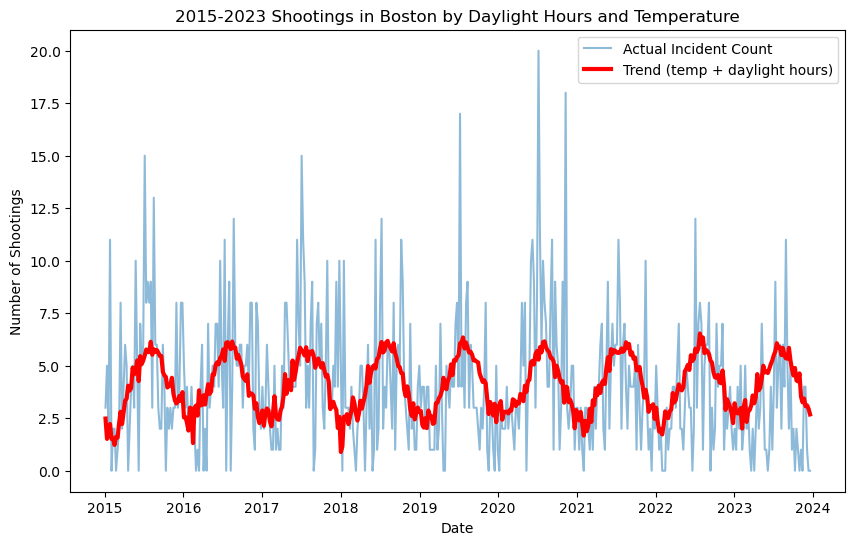

In [16]:
# Preparing X and y
X = shootings_weekly[['daylight_hours', 'TAVG']]
y = shootings_weekly['incident_count']

# Training
reg = LinearRegression().fit(X, y)

# Predicting
shootings_weekly['TAVG_daylight_trend'] = reg.predict(X)

# Plotting overall model fit
plt.figure(figsize=(10, 6))
plt.plot(shootings_weekly.index, shootings_weekly['incident_count'], 
         label='Actual Incident Count', alpha=0.5)
plt.plot(shootings_weekly.index, shootings_weekly['TAVG_daylight_trend'], 
         label='Trend (temp + daylight hours)', color='red', linewidth=3)
plt.title("2015-2023 Shootings in Boston by Daylight Hours and Temperature")
plt.xlabel('Date')
plt.ylabel('Number of Shootings')
plt.legend()
plt.show()

In [17]:
# checking in with our dataframe so far
shootings_weekly.head()

,AWND,PRCP,TAVG,incident_count,daylight_hours,daylight_trend,daylight_corrected_total,detrended,temp_trend,temp_corrected_total,TAVG_daylight_trend
DATE,,,,,,,,,,,
2015-01-05,67.79,1.19,33.200000,3.0,9.020912,2.762069,4.327675,4.327675,2.503378,4.586366,2.484089
2015-01-12,83.67,0.23,20.714286,5.0,9.157937,2.822920,6.266824,6.266824,1.510569,7.579174,1.516401
2015-01-19,80.52,0.27,27.000000,2.0,9.338895,2.903281,3.186462,3.186462,2.010381,4.079362,2.008196
2015-01-26,78.29,0.81,29.714286,11.0,9.558203,3.000673,12.089071,12.089071,2.226209,12.863534,2.223176
2015-02-02,102.91,1.85,20.571429,0.0,9.809899,3.112449,0.977295,0.977295,1.499210,2.590534,1.517375


### Precipitation and Other Factors

The analysis of precipitation data yields less compelling results compared to temperature and daylight hours. The coefficient indicates a marginal increase in shootings by 0.142 for each inch of rain, coupled with a notably low R-squared score of 2.698e-05.

Given these findings, precipitation does not appear to be a significant factor in our current model and will not be considered further at this stage.

This is a work in progress, so I'd love to add additional relevant factors into the model and updating it periodically. Suggestions and insights are always welcome, so please feel free to reach out with your thoughts!

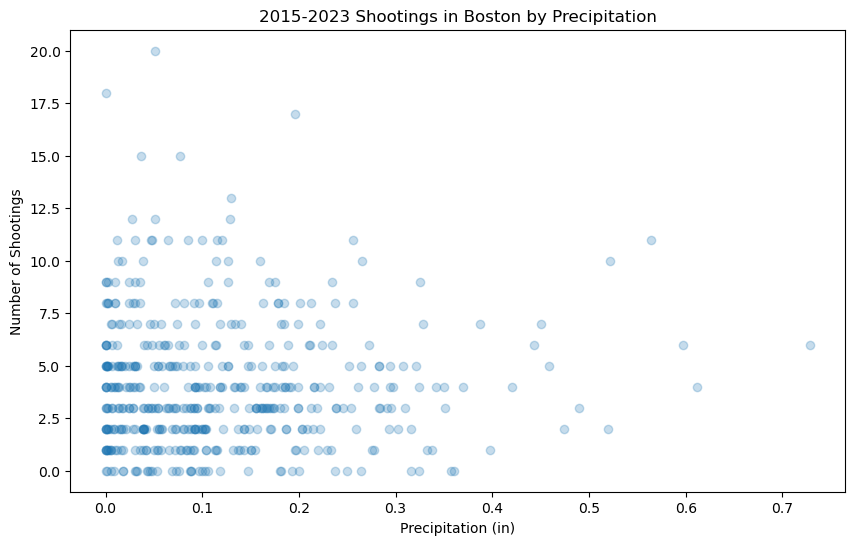

In [18]:
# plotting precipitation
plt.figure(figsize=(10,6))
plt.scatter(weather_weekly['PRCP'], shootings_weekly['incident_count'], alpha=0.25)
plt.title('2015-2023 Shootings in Boston by Precipitation')
plt.xlabel('Precipitation (in)')
plt.ylabel('Number of Shootings')
plt.show()

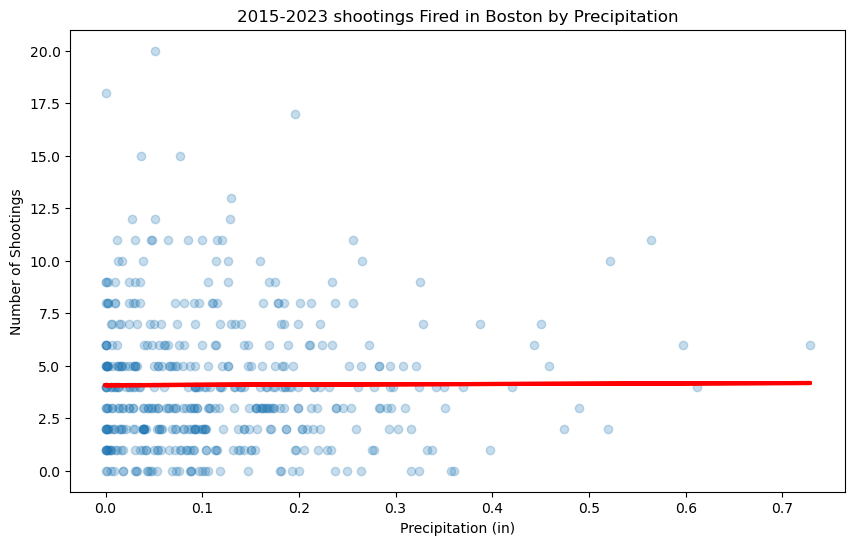

Coefficients: 
 [[0.14214701]]
Intercept: 
 [4.07310397]
R-squared: 
 2.6980461244940912e-05


In [19]:
# linear regression for precipitation

# we need to reshape the data for sklearn
precip = weather_weekly['PRCP'].values.reshape(-1, 1)
incident_count = shootings_weekly['incident_count'].values.reshape(-1, 1)

# creating the model
model = LinearRegression()
model.fit(precip, incident_count)

# let's plot the data and the line of best fit
plt.figure(figsize=(10,6))
plt.scatter(precip, incident_count, alpha=0.25)
plt.plot(precip, model.predict(precip), color='red', linewidth=3)
plt.title('2015-2023 shootings Fired in Boston by Precipitation')
plt.xlabel('Precipitation (in)')
plt.ylabel('Number of Shootings')
plt.show()

# let's print the coefficients
print('Coefficients: \n', model.coef_)
print('Intercept: \n', model.intercept_)
print('R-squared: \n', model.score(precip, incident_count))

### Final Detrended Data

With our detrended data now complete, it's important to clarify what it represents. This data doesn't directly reflect the actual number of shootings occurring each week. Instead, it shows the number of shootings that would be occurring in a given week if factors like temperature and daylight hours were not influencing the outcomes. Consequently, the observed spikes do not directly indicate surges in gun violence; rather, they represent deviations from what our model expects, accounting for these environmental factors.

/Users/mark/anaconda3/envs/ds/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


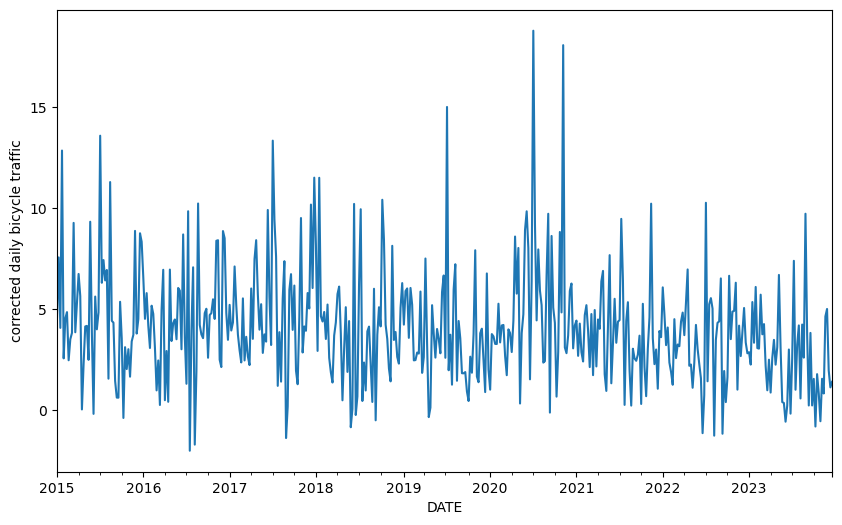

In [20]:
# let's detrend the data
trend = reg.predict(shootings_weekly[['daylight_hours', 'TAVG']].to_numpy())
shootings_weekly['all_detrended'] = shootings_weekly['incident_count'] - trend.flatten() + trend.mean()

# let's plot the detrended data
plt.figure(figsize=(10,6))
shootings_weekly['all_detrended'].plot()
plt.ylabel('corrected daily bicycle traffic');

### Smoothing The Data Out

To enhance the interpretability of our findings, the data has been smoothed using a 30-week moving average. This approach helps in reducing week-to-week variability and allows for a clearer observation of the longer-term trends present in the data.

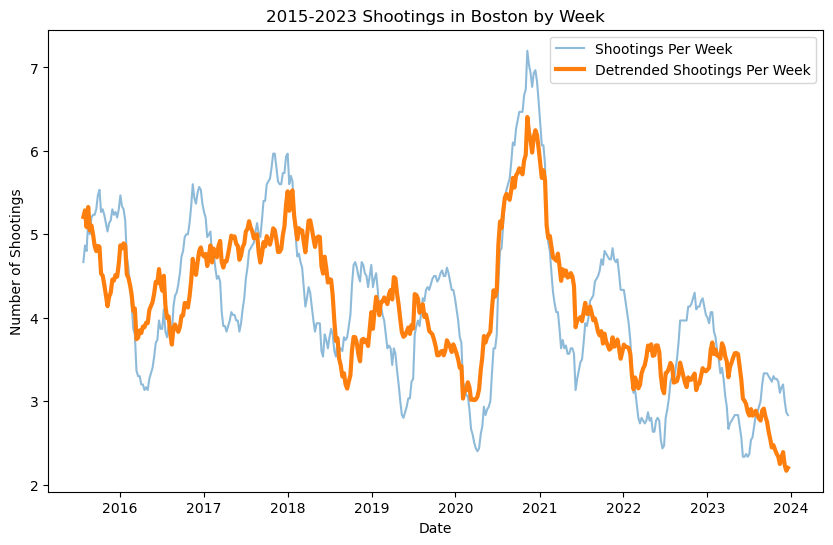

In [21]:
plt.figure(figsize=(10,6))
plt.plot(shootings_weekly['incident_count'].rolling(30).mean(), alpha=0.5)
plt.plot(shootings_weekly['all_detrended'].rolling(30).mean(), linewidth=3)
plt.legend(['Shootings Per Week', 'Detrended Shootings Per Week'])
plt.title('2015-2023 Shootings in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Number of Shootings')
plt.show()

### Conclusions

Having refined our data, the next step involves plotting a regression model to discern the overarching trend in Boston's gun violence. Encouragingly, the analysis yields positive news. Despite a significant spike in 2020 during the Covid-19 Pandemic, when factoring out the influences of weather and daylight, Boston not only stands as the capital of the state with the lowest rate of gun violence in the USA but is also continuing to trend in a positive direction.

Trend Coefficient: -0.0005706602520217025
Intercept: 5.022487771673062


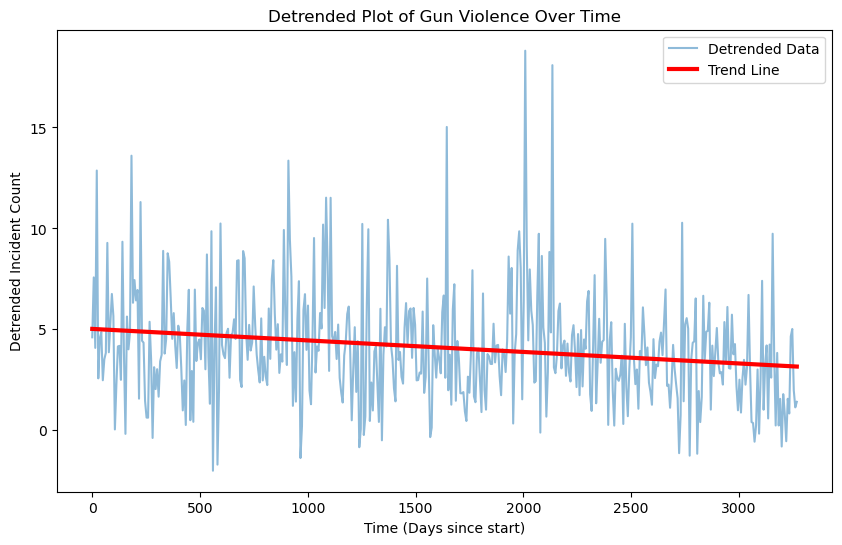

In [22]:
start_date = shootings_weekly.index.min()
shootings_weekly['time'] = (shootings_weekly.index - start_date).days

# Preparing X and y
X = shootings_weekly[['time']].values.reshape(-1, 1)  # Make sure it's in the right shape
y = shootings_weekly['all_detrended'].values

model = LinearRegression().fit(X, y)

print('Trend Coefficient:', model.coef_[0])
print('Intercept:', model.intercept_)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(shootings_weekly['time'], shootings_weekly['all_detrended'], label='Detrended Data', alpha=0.5)
plt.plot(shootings_weekly['time'], model.predict(X), color='red', linewidth=3, label='Trend Line')
plt.xlabel('Time (Days since start)')
plt.ylabel('Detrended Incident Count')
plt.title('Detrended Plot of Gun Violence Over Time')
plt.legend()
plt.show()

# also exporting to a csv for later use
shootings_weekly.to_csv('data/shootings_weekly.csv')

### Additional Thoughts

An important note here is to recognize that there is a significantly large disparity in race in Boston's shooting data. Black victims make up anywhere between 70-85% of the victims depending on the year.

The silver lining here is that as gun violence appears to be ramping down since 2021 in Boston, so too does the ratio of Black victims. While this doesn't address the disparity seen in the data, it does provide some **minor** relief that a reduction in overall gun violence is good for everyone, including Black communities.

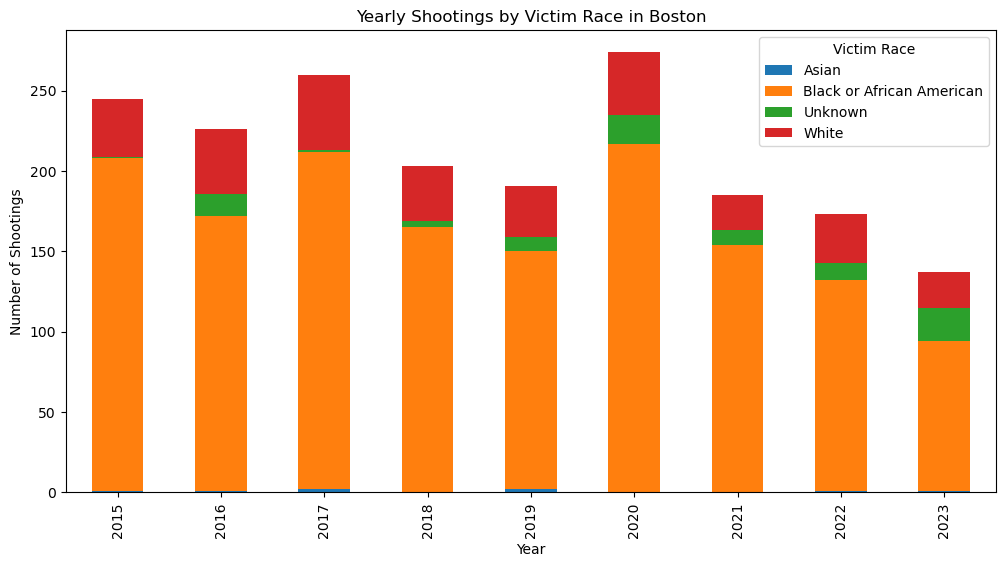

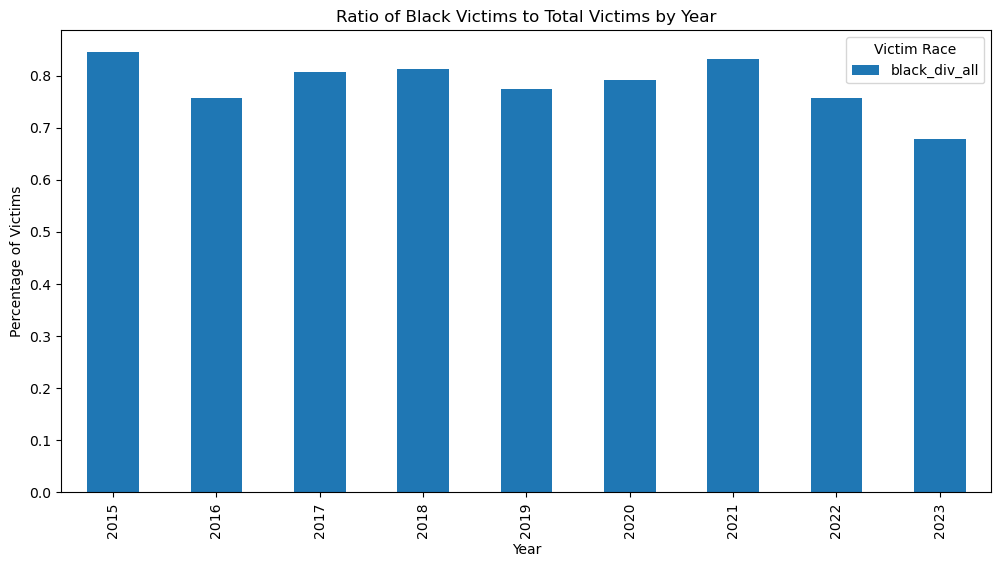

In [23]:
shootings['year'] = pd.to_datetime(shootings['shooting_date']).dt.year

race_yearly = shootings.groupby(['year', 'victim_race']).size().unstack()

# exporting to a csv for later use
race_yearly.to_csv('data/race_yearly.csv')

# Plotting
race_yearly.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Yearly Shootings by Victim Race in Boston')
plt.xlabel('Year')
plt.ylabel('Number of Shootings')
plt.legend(title='Victim Race')
plt.show()

race_yearly['total'] = race_yearly.sum(axis=1)
race_yearly['black_div_all'] = race_yearly['Black or African American']/race_yearly['total']
race_yearly['black_div_all'].plot(kind='bar', figsize=(12, 6))

plt.title('Ratio of Black Victims to Total Victims by Year')
plt.xlabel('Year')
plt.ylabel('Percentage of Victims')
plt.legend(title='Victim Race')
plt.show()

# exporting to a csv for later use
race_yearly.to_csv('data/race_yearly.csv')